Import: modules, functions, classes, variables

In [1]:
import datetime  # Нужно ли в этой тетрадке ?

import numpy as np
import pandas as pd
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sys import path
from os import getcwd
from math import isinf
from pickle import dump
from scipy.stats import shapiro
from warnings import simplefilter
from plotly.offline import init_notebook_mode
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

from statsmodels.graphics.tsaplots import plot_acf as autocorr_plot

Set project settings

In [2]:
%matplotlib inline
init_notebook_mode(connected=True)
simplefilter(action="ignore", category=Warning)

Include handwritten modules

In [3]:
modules_path = "../../../src/"

In [4]:
path.append(modules_path)

In [5]:
from auxiliary import *
from feature_engineering import *

Load processed dataframe

In [6]:
processed_df = pd.read_parquet(processed_data_path + getcwd().split("\\")[-1] + processed_data_name)

In [7]:
processed_df.head(7)

,peak_hour
days,
2012-04-02,11
2012-04-03,11
2012-04-04,11
2012-04-05,11
2012-04-06,11
2012-04-09,21
2012-04-10,11


In [8]:
processed_df.tail(7)

,peak_hour
days,
2024-08-22,16
2024-08-23,15
2024-08-26,16
2024-08-27,16
2024-08-28,15
2024-08-29,16
2024-08-30,15


Time series time step is a day

Time series has a day gaps

In [9]:
print("Counter of weekend days =", sum((processed_df.index.dayofweek + 1) > 5))

Counter of weekend days = 12


The gaps are weekends

In [10]:
processed_df[(processed_df.index.dayofweek + 1) > 5]

,peak_hour
days,
2012-04-28,11
2012-05-05,11
2012-05-12,11
2012-06-09,11
2012-12-29,19
2016-02-20,19
2018-04-28,11
2018-06-09,11
2018-12-29,18


Available days off are working days

In [11]:
print("Processed dataframe has a", sum(create_holiday_feature(processed_df)), "holidays")

Processed dataframe has a 0 holidays


Processed dataframe hasn't a holidays

In [12]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3055 entries, 2012-04-02 to 2024-08-30
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   peak_hour  3055 non-null   int64
dtypes: int64(1)
memory usage: 47.7 KB


1) The first date is `2012-04-02`
2) The last date is `2024-07-31`

In [13]:
print("The full processed dataframe should contain", (processed_df.index[-1] - processed_df.index[0]).days, "days")

The full processed dataframe should contain 4533 days


Processed dataframe has a 3033 days

In [14]:
print("Our processed dataframe doesn't have a", round(1 - 3033 / 4503, 2), "% of the full time series")

Our processed dataframe doesn't have a 0.33 % of the full time series


In [15]:
processed_df.describe()

,peak_hour
count,3055.000000
mean,16.814075
std,3.498638
min,10.000000
25%,15.000000
50%,18.000000
75%,20.000000
max,21.000000


1) The typical target value is 18
2) Standart deviation of the target is 20 % of the target mean 
3) The target interquartile range is 5, the target variability is high
4) The minium target value is smaller in 2.1 times than the maximum target value
5) Many unique target values are in the first quartile, we have a lot of rare target values

In [16]:
print("Processed dataframe has next years:", ", ".join([str(year) for year in processed_df.index.year.unique()]))

Processed dataframe has next years: 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024


Processed dataframe starts from 2012 to 2024 year

In [17]:
[print("Year", str(time_components[0]) + ":\n     Included month numbers:", *time_components[1], "\n") for
 time_components in
 zip(processed_df.index.year.unique(), [months for months in
                                        [processed_df[processed_df.index.year == year].index.month.unique() for year in
                                         [year for year in processed_df.index.year.unique()]]])];

Year 2012:
     Included month numbers: 4 5 6 7 8 9 10 11 12 

Year 2013:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2014:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2015:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2016:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2017:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2018:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2019:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2020:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2021:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2022:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2023:
     Included month numbers: 1 2 3 4 5 6 7 8 9 10 11 12 

Year 2024:
     Included month numbers: 1 2 3 4 5 6 7 8 



The border years are incomplete

In [18]:
analyt_df = processed_df.copy()

In [19]:
analyt_df["year"] = analyt_df.index.year
analyt_df["day_of_year"] = analyt_df.index.dayofyear

Processed data visualisation

In [20]:
scatters_plot(analyt_df, "day_of_year", "peak_hour", "year", "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)",
              "Day of year",
              "Peak hour")

Processed dataframe has an emissions

Let's replace them by nearby values

In [21]:
processed_df[processed_df["peak_hour"] == 10] = 11

In [22]:
processed_df[(processed_df.index.year == 2019) & (processed_df.index.dayofyear == 197)] = 17

In [23]:
processed_df[(processed_df.index.year == 2023) & (processed_df.index.dayofyear == 303)] = 18

In [24]:
processed_df[
    (processed_df.index.year == 2024) & (processed_df.index.dayofyear <= 31) & (processed_df["peak_hour"] == 11)] = 18

In [25]:
processed_df[
    (processed_df.index.year == 2014) & (processed_df.index.dayofyear <= 31) & (processed_df["peak_hour"] == 11)] = 18

In [26]:
analyt_df = processed_df.copy()

Repeat processed data visualisation

In [27]:
analyt_df["year"] = analyt_df.index.year
analyt_df["day_of_year"] = analyt_df.index.dayofyear

In [28]:
scatters_plot(analyt_df, "day_of_year", "peak_hour", "year", "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)",
              "Day of year",
              "Peak hour")

The processed data is noisy and weakly follows the pattern

Let's compare every neighboring years

In [29]:
scatters_plot(analyt_df[(analyt_df.index.year == 2012) | (analyt_df.index.year == 2013)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [30]:
scatters_plot(analyt_df[(analyt_df.index.year == 2013) | (analyt_df.index.year == 2014)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [31]:
scatters_plot(analyt_df[(analyt_df.index.year == 2014) | (analyt_df.index.year == 2015)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [32]:
scatters_plot(analyt_df[(analyt_df.index.year == 2015) | (analyt_df.index.year == 2016)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [33]:
scatters_plot(analyt_df[(analyt_df.index.year == 2016) | (analyt_df.index.year == 2017)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [34]:
scatters_plot(analyt_df[(analyt_df.index.year == 2017) | (analyt_df.index.year == 2018)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [35]:
scatters_plot(analyt_df[(analyt_df.index.year == 2018) | (analyt_df.index.year == 2019)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [36]:
scatters_plot(analyt_df[(analyt_df.index.year == 2019) | (analyt_df.index.year == 2020)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [37]:
scatters_plot(analyt_df[(analyt_df.index.year == 2020) | (analyt_df.index.year == 2021)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [38]:
scatters_plot(analyt_df[(analyt_df.index.year == 2021) | (analyt_df.index.year == 2022)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [39]:
scatters_plot(analyt_df[(analyt_df.index.year == 2022) | (analyt_df.index.year == 2023)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In [40]:
scatters_plot(analyt_df[(analyt_df.index.year == 2023) | (analyt_df.index.year == 2024)], "day_of_year", "peak_hour",
              "year",
              "ANNUAL COMPARISON OF PEAK HOURS (SCATTERPLOT)", "Day of year", "Peak hour")

In the analysis we will use whole years of the time series.

That means thath we will cut a part of old data, because the new data is more important.

* Target distribution:

In [41]:
# # ?
# def graph_plot(graph_type: str, graph_data: pd.DataFrame, graph_target_name: str, graph_x_label: str,
#                graph_y_label: str, graph_title: str, graph_grid: bool, graph_x_size: int = 10, graph_y_size: int = 10,
#                graph_feature_name: str = None):
#     plt.figure(figsize=(graph_x_size, graph_y_size))

#     if graph_type == "countplot":
#         sns.countplot(x=graph_target_name, data=graph_data)

#     plt.xlabel(graph_x_label)
#     plt.ylabel(graph_y_label)
#     plt.title(graph_title)

#     if graph_grid:

#     ...

In [42]:
# graph_plot("countplot", processed_df, "peak_hour", "Peak hour", "Hour frequency", "Peak Hours (Countplot)", True, 15, 3)

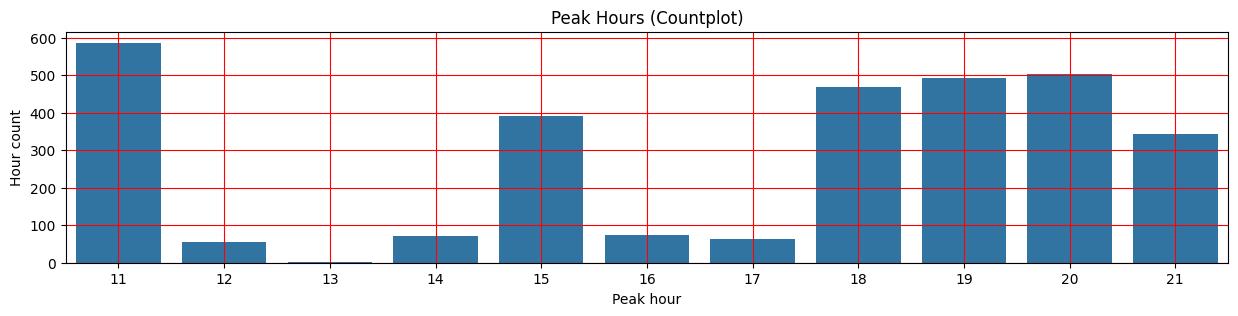

In [43]:
plt.figure(figsize=(15, 3))
sns.countplot(x="peak_hour", data=processed_df)
plt.xlabel("Peak hour")
plt.ylabel("Hour count")
plt.title("Peak Hours (Countplot)")
plt.grid(color='r', linestyle='-');

Does target has a normal distribution?

In [44]:
print("Answer:", str(shapiro(analyt_df["peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

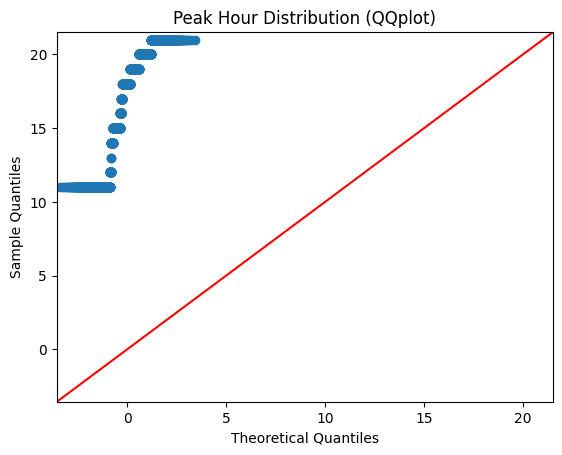

In [45]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["peak_hour"], line="45")
plt.title("Peak Hour Distribution (QQplot)");

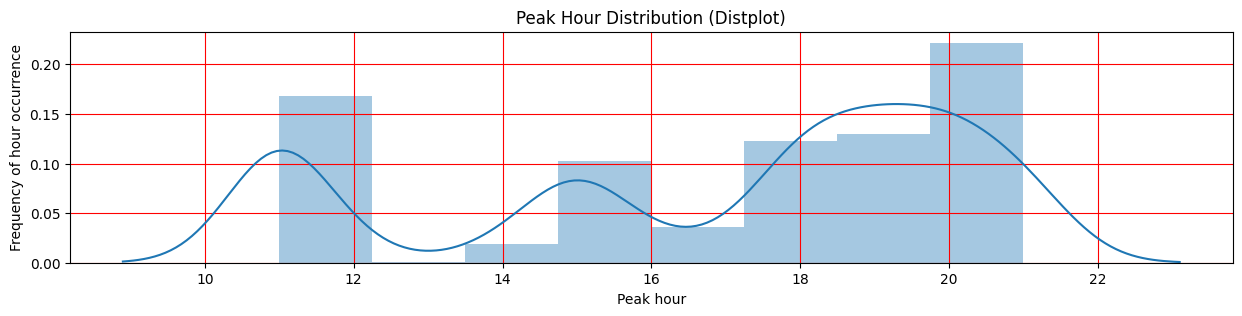

In [46]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["peak_hour"], bins=8, hist=True)
plt.xlabel("Peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

Obviously, the target distribution is not normal.

________________________________________________________________________________________________________________________________________________________

* Target trend:

In [47]:
analyt_df = processed_df["2012-08":].copy()

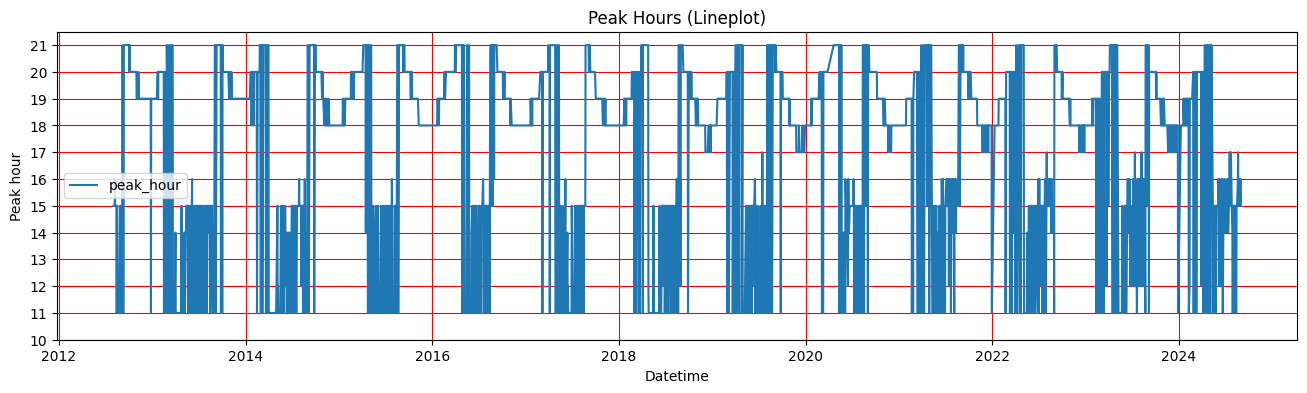

In [48]:
plt.figure(figsize=(16, 4))
figure = sns.lineplot(analyt_df)
figure.set_yticks([_ for _ in range(10, 22)])
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [49]:
get_average_months_length(processed_df, 2013, 2023)

22

In [50]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "peak_hour", "mean", get_average_months_length(analyt_df, 2013, 2023) * 6)
).trend + ".")

Answer: increasing.


Visualise our suggest:

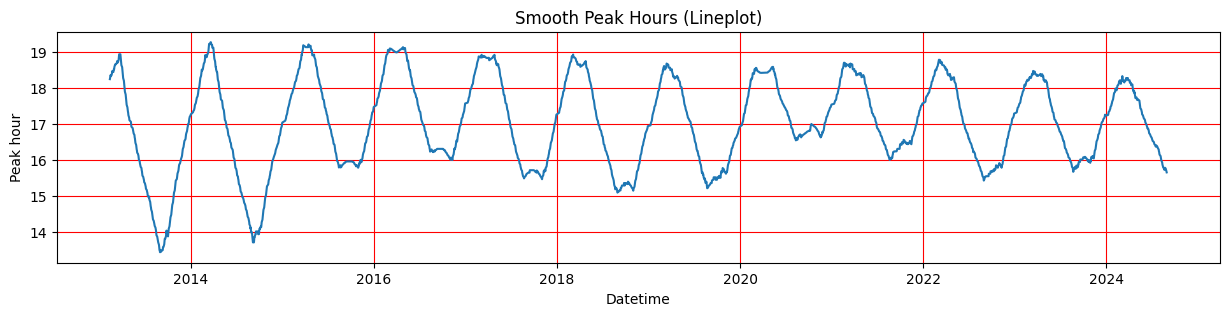

In [51]:
plt.figure(figsize=(15, 3))
sns.lineplot(
    create_rolling_window_feature(analyt_df, "peak_hour", "mean", get_average_months_length(analyt_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [52]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "peak_hour", "mean",
                                                                       get_average_months_length(analyt_df, 2013, 2023)
                                                                       * 6)

analyt_df.dropna(inplace=True)

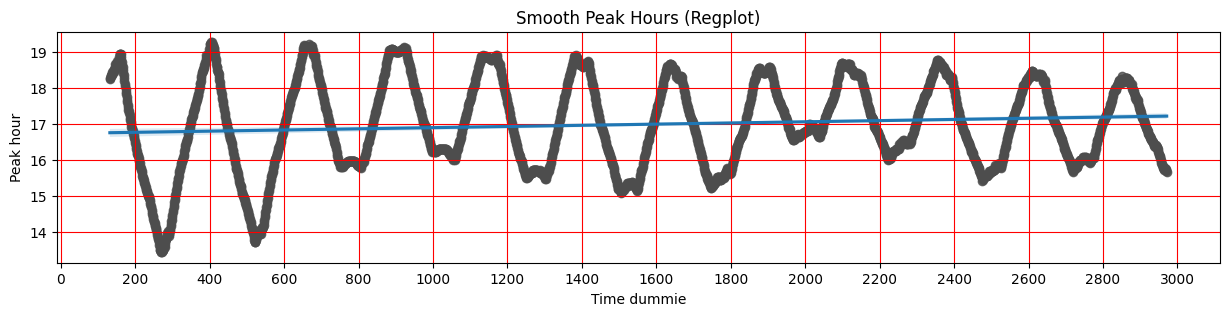

In [53]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(0, 3050, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a fake trend and a big dispersion.

Let's see plot without the first part of the target to be sure that we don't have a generally trend:

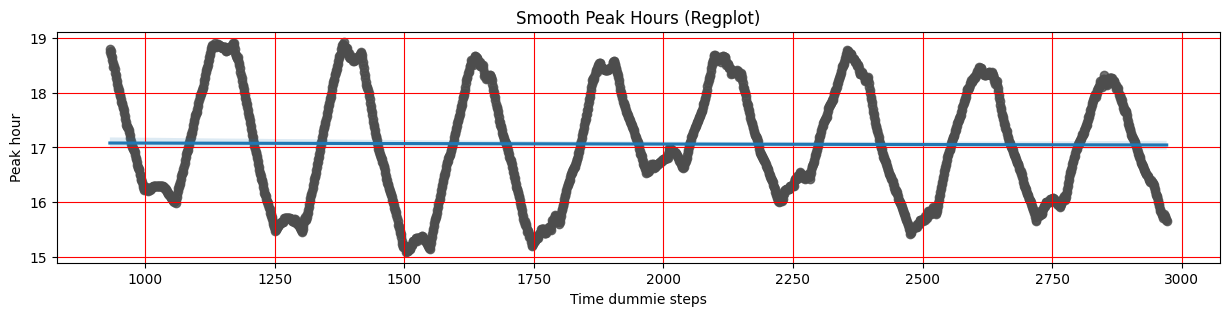

In [54]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df.iloc[800:], scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

And check the first part of the target to see trend:

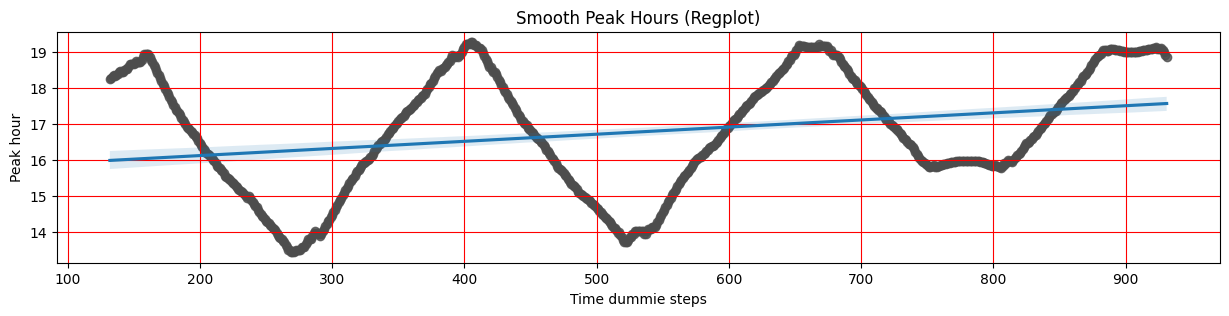

In [55]:
plt.figure(figsize=(15, 3))
sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df.iloc[: 800], scatter_kws=dict(color="0.30"));
plt.xlabel("Time dummie steps")
plt.ylabel("Peak hour")
plt.title("Smooth Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The trend exists only in part of the data.

It means that we need to normalised target.

_________________________________________________________________________________________________________________________________________________________

* Target normalization:

In [56]:
featured_df = processed_df.copy()

We will use a moved windows for the target normalization and forecasting.

The size of the step - 1 day.

In [57]:
featured_df = normalization(featured_df, "peak_hour")

In [58]:
featured_df.head(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2012-04-02,11,NaN,NaN,NaN
2012-04-03,11,NaN,NaN,NaN


In [59]:
featured_df.tail(2)

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour
days,,,,
2024-08-29,16,1.574242,14.682540,0.836885
2024-08-30,15,1.582515,14.698413,0.190575


We can have infinity and missing values after normalization in target.

In [60]:
featured_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3055 entries, 2012-04-02 to 2024-08-30
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   peak_hour             3055 non-null   int64  
 1   std_normalization     2992 non-null   float64
 2   mean_normalization    2992 non-null   float64
 3   normalized_peak_hour  2992 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 183.9 KB


In [61]:
featured_df[featured_df["normalized_peak_hour"].isna()].index.values[: 15]

array(['2012-04-02T00:00:00.000000000', '2012-04-03T00:00:00.000000000',
       '2012-04-04T00:00:00.000000000', '2012-04-05T00:00:00.000000000',
       '2012-04-06T00:00:00.000000000', '2012-04-09T00:00:00.000000000',
       '2012-04-10T00:00:00.000000000', '2012-04-11T00:00:00.000000000',
       '2012-04-12T00:00:00.000000000', '2012-04-13T00:00:00.000000000',
       '2012-04-16T00:00:00.000000000', '2012-04-17T00:00:00.000000000',
       '2012-04-18T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2012-04-20T00:00:00.000000000'], dtype='datetime64[ns]')

As we can see we have missing target only at the beginning of data.

This is because we use moving average window, it's ok.

How many infinity values do we have in the data?

In [62]:
print("Answer:", str(sum(featured_df["normalized_peak_hour"].apply(isinf))) + '.')

Answer: 0.


The last one, let's check up our normalized target:

In [63]:
featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [64]:
featured_df["mean"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean", 22)

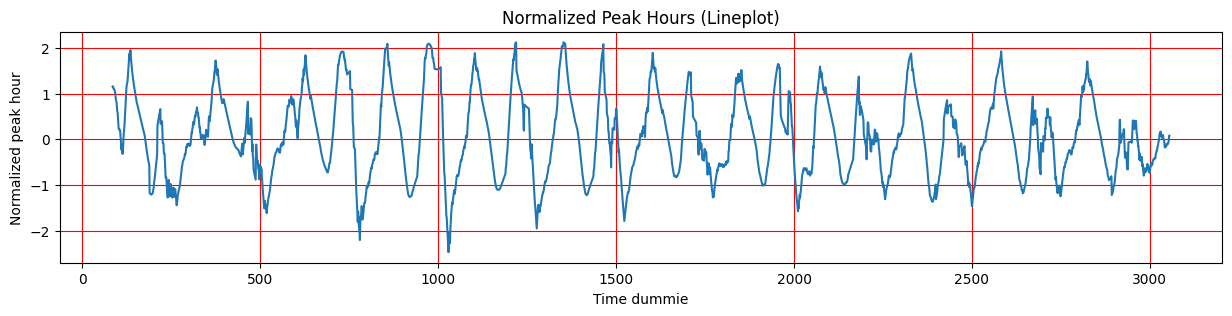

In [65]:
plt.figure(figsize=(15, 3))
sns.lineplot(data=featured_df, x="time_dummie", y="mean")
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

In [66]:
featured_df["normalized_peak_hour"].describe()

count    2992.000000
mean        0.082288
std         1.561112
min       -15.996301
25%        -0.771799
50%         0.202058
75%         1.019603
max         4.411488
Name: normalized_peak_hour, dtype: float64

1) We have the significant deviation of the target - 2023 % of the average value
2) Many target values are in the first quartile
3) Few target values are in the third quartile
4) The minium target value is smaller in 4.35 times than the maximum target valu

Df doesn't have missing and infinity target values, but it has outliers.

________________________________________________________________________________________________________________________________________________________

* Normalized target distribution:

In [67]:
analyt_df = featured_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

Does the normalized target has a normal distribution?

In [68]:
print("Answer:", str(shapiro(analyt_df["normalized_peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

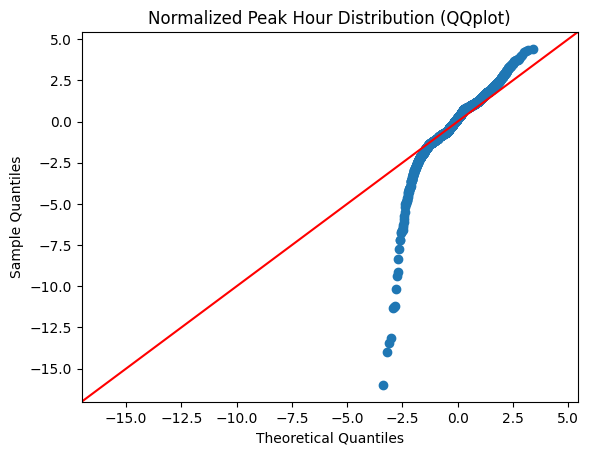

In [69]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["normalized_peak_hour"], line="45")
plt.title("Normalized Peak Hour Distribution (QQplot)");

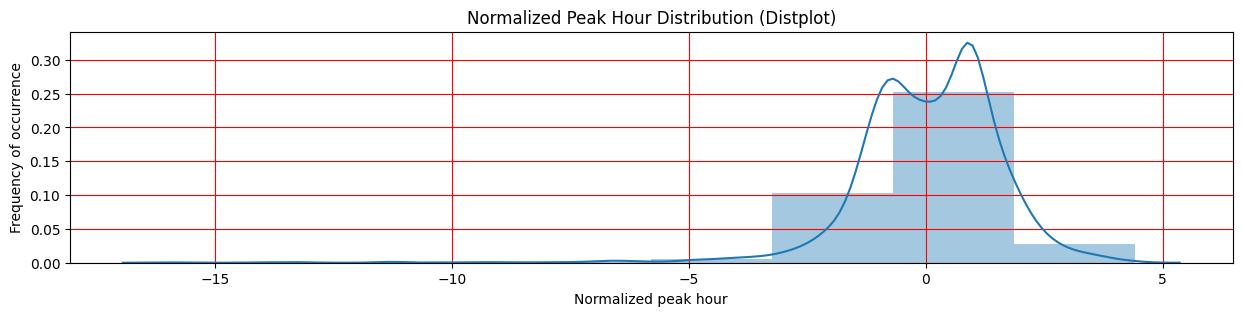

In [70]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Normalized peak hour")
plt.ylabel("Frequency of occurrence")
plt.title("Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The target distribution is not normal, but is close to normal.

_________________________________________________________________________________________________________________________________________________________

* Normalized target trend:

In [71]:
analyt_df = featured_df["normalized_peak_hour"]["2012-08":].copy().dropna().to_frame()

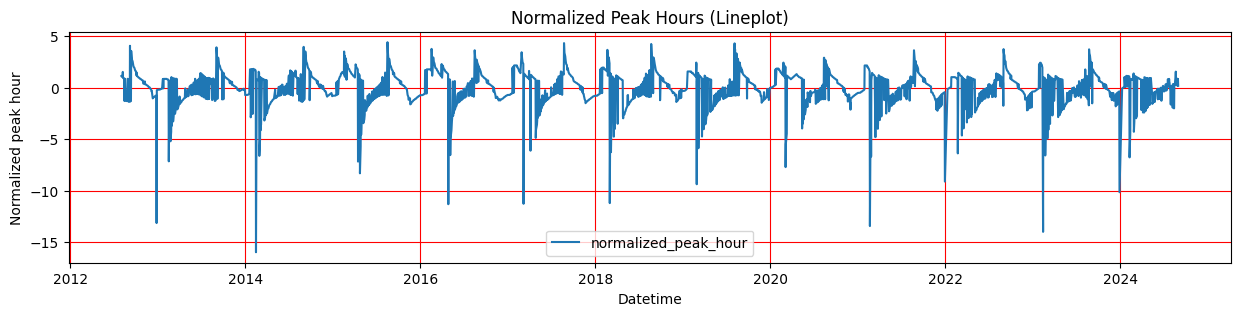

In [72]:
plt.figure(figsize=(15, 3))
sns.lineplot(analyt_df)
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does the normalized target has a trend?

In [73]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean", get_average_months_length(analyt_df, 2013,
                                                                                                       2023) * 6)).trend + ".")

Answer: decreasing.


Visualise our suggest:

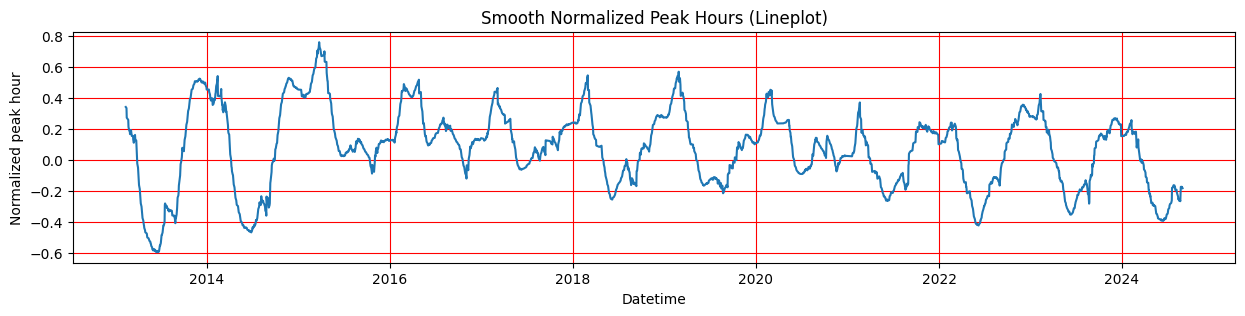

In [74]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_df, 2013, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [75]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2013, 2023) * 6)

analyt_df.dropna(inplace=True)

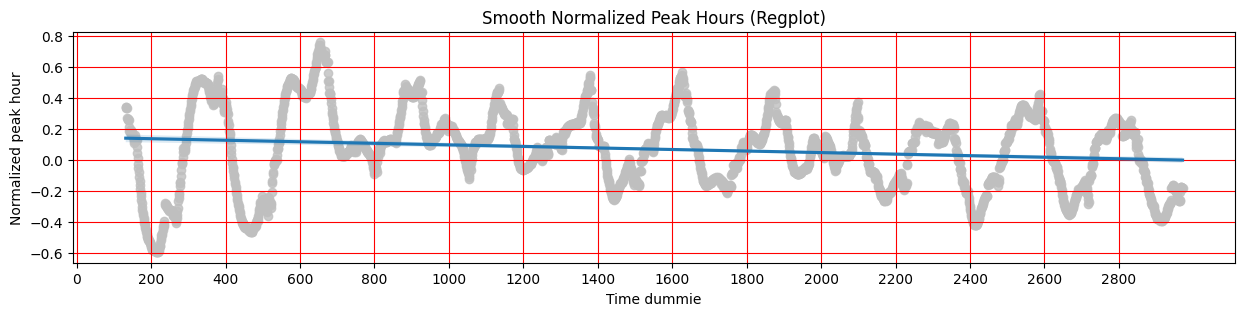

In [76]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 3000, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

The normalized target has a trend.

_________________________________________________________________________________________________________________________________________________________

* The normalized target trend model:

The normalized target has a decreasing trend.

Let's cut a data from beginning, because we have leap at the first time.

This leap is exists because in 2014 year was a political problems which effect on economic and electro consumption.

Let's watch trend plots with difference windows size:

In [77]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [78]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["quarter_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                    get_average_months_length(analyt_df, 2015,
                                                                                              2023) * 3)

analyt_df.dropna(inplace=True)

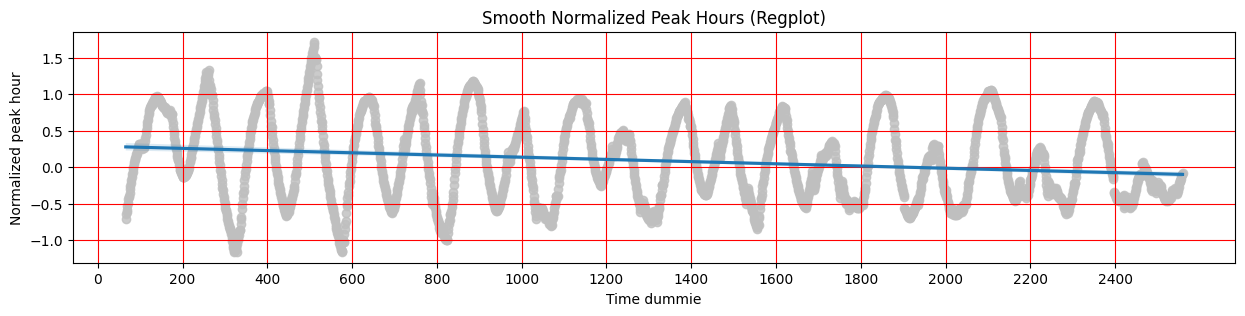

In [79]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="quarter_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [80]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [81]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

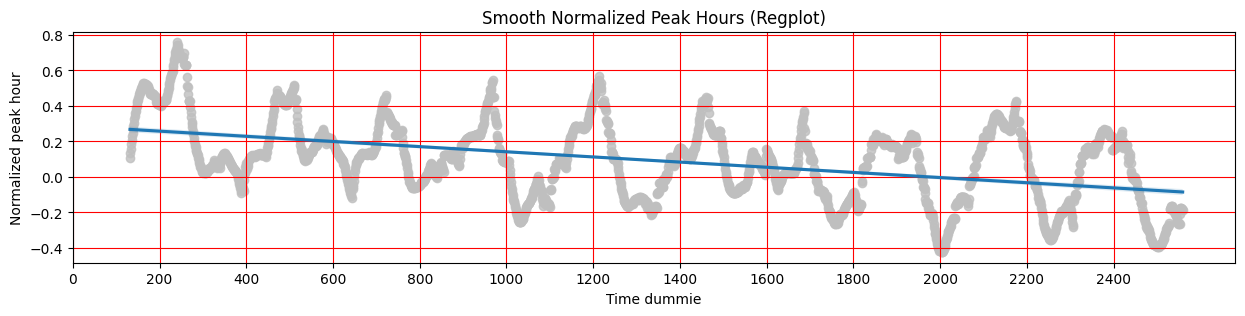

In [82]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(0, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [83]:
analyt_df = featured_df["normalized_peak_hour"]["2014-04":].copy().dropna().to_frame()

In [84]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["annual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                   get_average_months_length(analyt_df, 2015,
                                                                                             2023) * 12)

analyt_df.dropna(inplace=True)

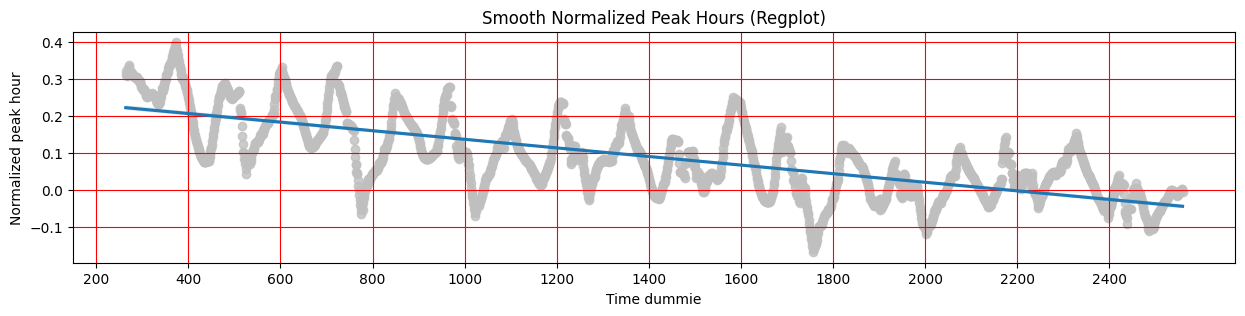

In [85]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Definitely, we have the linear trend.

At first, delete target data before `2014-04`:

In [86]:
featured_df = featured_df["2014-04":]

Let's create a trend model:

In [87]:
analyt_df = featured_df["normalized_peak_hour"].copy().dropna().to_frame()

In [88]:
y = analyt_df["normalized_peak_hour"]

In [89]:
y.head(2)

days
2014-04-01   -2.509083
2014-04-02   -2.353704
Name: normalized_peak_hour, dtype: float64

In [90]:
y.tail(2)

days
2024-08-29    0.836885
2024-08-30    0.190575
Name: normalized_peak_hour, dtype: float64

In [91]:
dp = DeterministicProcess(index=y.index, order=1)
x = dp.in_sample()

In [92]:
x.head(2)

,trend
days,
2014-04-01,1.0
2014-04-02,2.0


In [93]:
x.tail(2)

,trend
days,
2024-08-29,2558.0
2024-08-30,2559.0


In [94]:
trend_model = LinearRegression()

In [95]:
trend_model.fit(x, y)

LinearRegression()

We will make prediction to subtract trend from trend (detrending):

In [96]:
y_pred = pd.Series(trend_model.predict(x), index=x.index)

Let's detrending our time series:

In [97]:
featured_df["normalized_peak_hour"] = featured_df["normalized_peak_hour"] - y_pred

And check up updated normalized target:

In [98]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [99]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

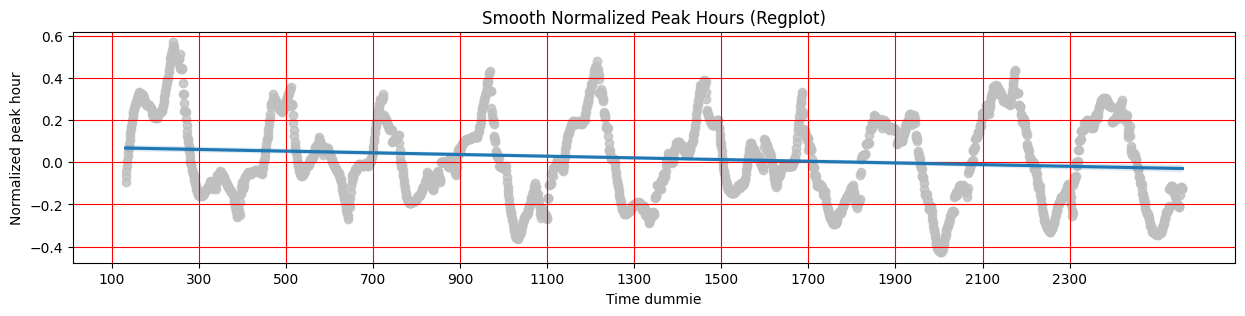

In [100]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.75"));
figure.set_xticks([_ for _ in range(100, 2350, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Normalized peak hour")
plt.title("Smooth Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

Detrending works.

Let's save our trend model:

In [101]:
model_name = "trend_model.sav"
model_path = "../../../models/Московская область/"

In [102]:
dump(trend_model, open(model_path + model_name, "wb"))

So let's check up the updated target data:

In [103]:
featured_df["normalized_peak_hour"].to_frame().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2559 entries, 2014-04-01 to 2024-08-30
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   normalized_peak_hour  2559 non-null   float64
dtypes: float64(1)
memory usage: 104.5 KB


In [104]:
featured_df["normalized_peak_hour"].to_frame().describe()

,normalized_peak_hour
count,2.559000e+03
mean,-9.718248e-18
std,1.532429e+00
min,-1.399412e+01
25%,-8.805148e-01
50%,1.094766e-01
75%,9.815888e-01
max,4.240317e+00


Most of the data is biased in the negative direction.

________________________________________________________________________________________________________________________________________________________

* Detrended normalized target distribution:

In [105]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

Does the detrended normalized target has a normal distribution?

In [106]:
print("Answer:", str(shapiro(analyt_df["normalized_peak_hour"])[1] > 0.05) + '.')

Answer: False.


Visualise our suggest:

<Figure size 1200x400 with 0 Axes>

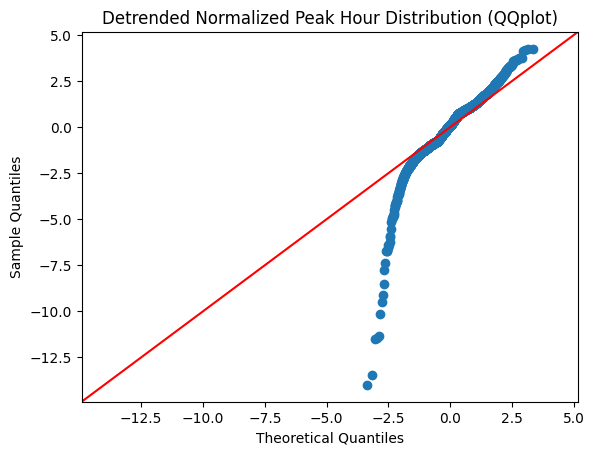

In [107]:
plt.figure(figsize=(12, 4))
sm.qqplot(analyt_df["normalized_peak_hour"], line="45")
plt.title("Detrended Normalized Peak Hour Distribution (QQplot)");

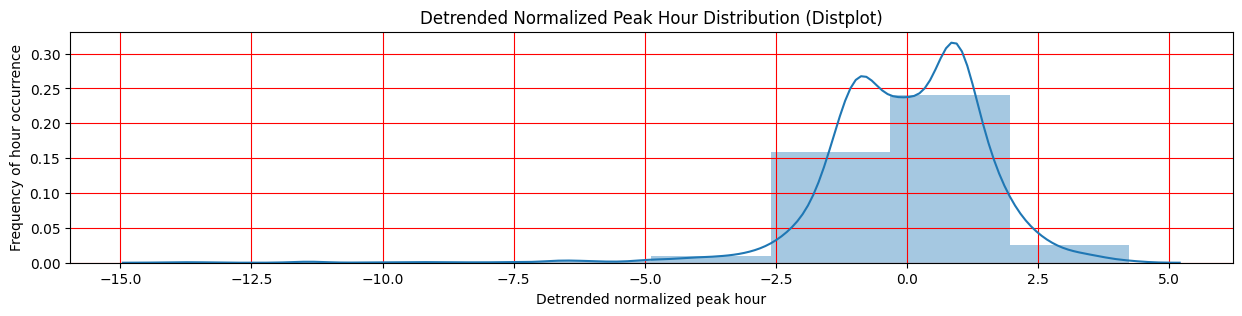

In [108]:
plt.figure(figsize=(15, 3))
sns.distplot(analyt_df["normalized_peak_hour"], bins=8, hist=True)
plt.xlabel("Detrended normalized peak hour")
plt.ylabel("Frequency of hour occurrence")
plt.title("Detrended Normalized Peak Hour Distribution (Distplot)")
plt.grid(color='r', linestyle='-');

The distribution is still not normal.

________________________________________________________________________________________________________________________________________________________

* The detrended normalized target trend:

In [109]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

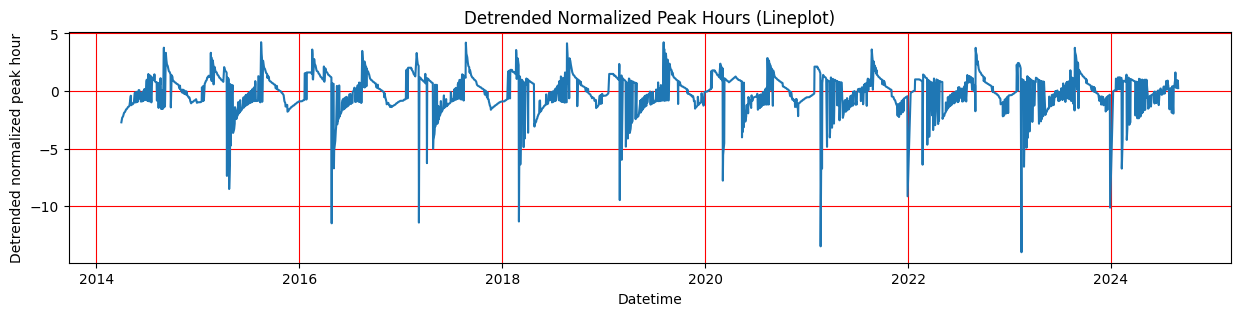

In [110]:
plt.figure(figsize=(15, 3))
figure = sns.lineplot(analyt_df["normalized_peak_hour"])
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's check half year windows to avoid big dispersion and noise.

Does target has a trend?

In [111]:
print("Answer:", mk.original_test(
    create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean", get_average_months_length(analyt_df, 2015,
                                                                                                       2023) * 6)).trend + ".")

Answer: decreasing.


Visualise our suggest:

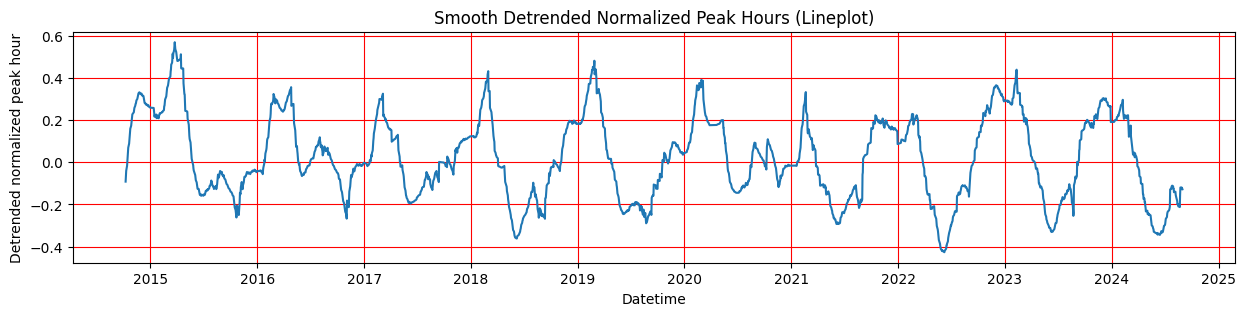

In [112]:
plt.figure(figsize=(15, 3))
sns.lineplot(create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                           get_average_months_length(analyt_df, 2015, 2023) * 6))
plt.xlabel("Datetime")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Lineplot)")
plt.grid(color='r', linestyle='-');

Let's take a closer look:

In [113]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [114]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["semiannual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                       get_average_months_length(analyt_df,
                                                                                                 2015, 2023) * 6)

analyt_df.dropna(inplace=True)

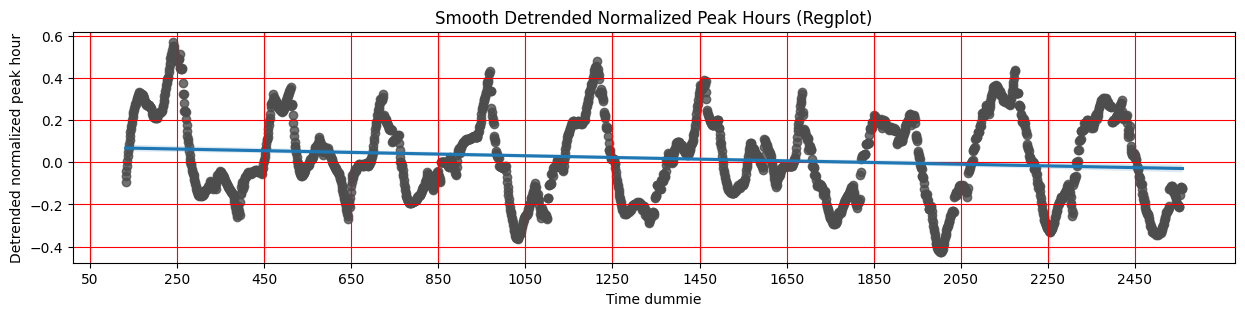

In [115]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="semiannual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(50, 2600, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

In [116]:
analyt_df = featured_df["normalized_peak_hour"].copy().to_frame()

In [117]:
analyt_df["time_dummie"] = create_time_dummie_feature(analyt_df)
analyt_df["annual_rolling_window"] = create_rolling_window_feature(analyt_df, "normalized_peak_hour", "mean",
                                                                   get_average_months_length(analyt_df, 2015,
                                                                                             2023) * 12)

analyt_df.dropna(inplace=True)

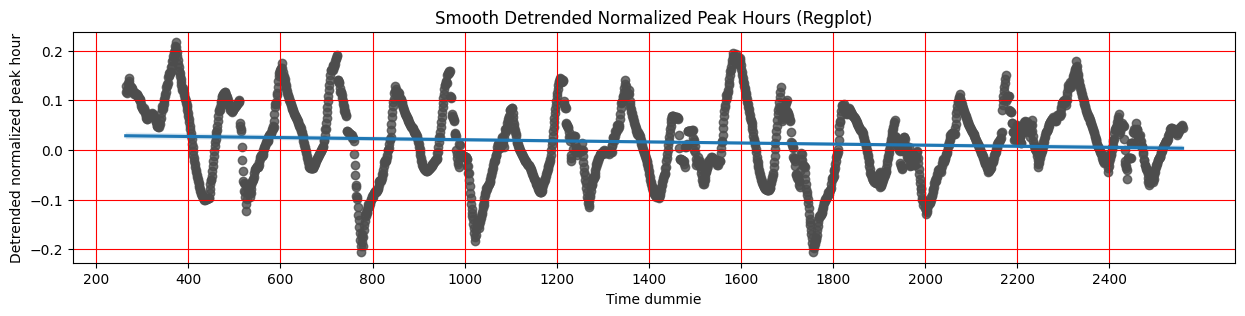

In [118]:
plt.figure(figsize=(15, 3))
figure = sns.regplot(x="time_dummie", y="annual_rolling_window", data=analyt_df, scatter_kws=dict(color="0.3"));
figure.set_xticks([_ for _ in range(200, 2500, 200)])
plt.xlabel("Time dummie")
plt.ylabel("Detrended normalized peak hour")
plt.title("Smooth Detrended Normalized Peak Hours (Regplot)")
plt.grid(color='r', linestyle='-');

We have a very little trend.

It will be better to ignore it.

_________________________________________________________________________________________________________________________________________________________

* The detrended normalized target periods:

In [119]:
zxc_index = featured_df["normalized_peak_hour"]
freq = 245

In [120]:
time = np.arange(len(zxc_index), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    zxc = pd.DataFrame(features, index=zxc_index)

In [121]:
# plot_periodogram(featured_df["peak_hour"]["2015": ])

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

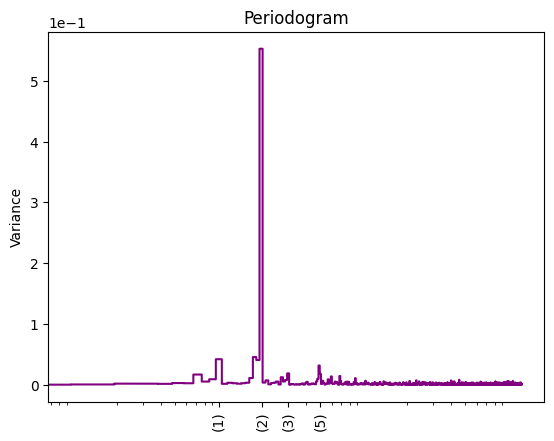

In [122]:
plot_periodogram(featured_df["normalized_peak_hour"])

In [123]:
sm = 0
cnt = 0

for year in range(2015, 2023):
    sm += analyt_df[analyt_df.index.year == year].shape[0]
    cnt += 1

year_days_count = sm / cnt

In [124]:
# X = analyt_df["normalized_peak_hour"].copy().to_frame()
# X["day"] = X.index.dayofweek + 1
# X["week"] = X.index.isocalendar().week
# X["dayofyear"] = X.index.dayofyear
# X["year"] = X.index.year

In [125]:
# seasonal_plot(X["2019-04": "2020-04"], y="normalized_peak_hour", period="week", freq="day")

паттерна нет

In [126]:
# seasonal_plot(X, y="normalized_peak_hour", period="year", freq="dayofyear");

есть паттерн годовой

Год, пол года, квартал, 5 месяцев

Недельной нет.

In [127]:
days = np.arange(len(featured_df["normalized_peak_hour"])) + 1

In [128]:
# # res1 = create_fourier_features(days, year_days_count)
# # res2 = create_fourier_features(days, (year_days_count + 1) // 2)
# # res3 = create_fourier_features(days, (year_days_count + 1) // 5)

# year_sin = pd.Series(np.sin(2 * np.pi * days / 247 * 2.02))
# year_cos = pd.Series(np.cos(2 * np.pi * days / 247 * 2.02))

# res = pd.concat({"year_cos": year_cos, "year_sin": year_sin}, axis=1)

# # res = pd.concat([res1, res2, res3], axis=1)

In [129]:
season_model = LinearRegression(fit_intercept=False)
_ = season_model.fit(zxc, featured_df["normalized_peak_hour"])

In [130]:
y_pred = pd.Series(season_model.predict(zxc), index=featured_df["normalized_peak_hour"].index)

In [131]:
y_pred

days
2014-04-01    0.475505
2014-04-02    0.468370
2014-04-03    0.458135
2014-04-04    0.444347
2014-04-07    0.426593
                ...   
2024-08-26    1.546694
2024-08-27    1.577674
2024-08-28    1.601459
2024-08-29    1.617802
2024-08-30    1.626523
Length: 2559, dtype: float32

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

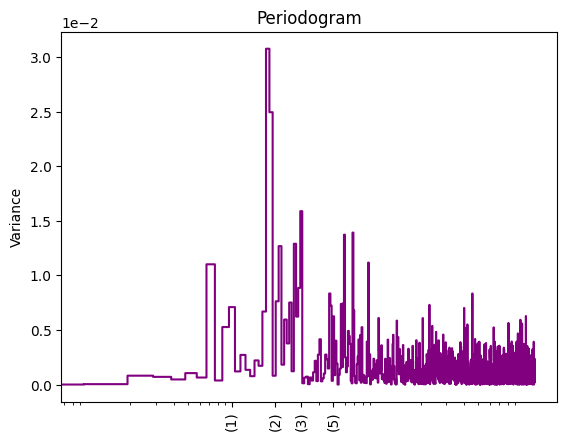

In [132]:
plot_periodogram(featured_df["normalized_peak_hour"] - y_pred)

In [133]:
featured_df["normalized_peak_hour"] = featured_df["normalized_peak_hour"] - y_pred

In [134]:
model_name = "season_model.sav"
model_path = "../../../models/Московская область/"
dump(trend_model, open(model_path + model_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

* Check normalize target correlation:

In [135]:
analyt_df = featured_df["normalized_peak_hour"].copy().dropna().to_frame()

In [136]:
# print("Does normalized data a autocorrelation?")
# print("Answer:", f'{max(sm.tsa.acf(analyt_df["normalized_peak_hour"])[1:]) > 0.4}.')
# print("Visualise our suggest.")

<Figure size 2000x400 with 0 Axes>

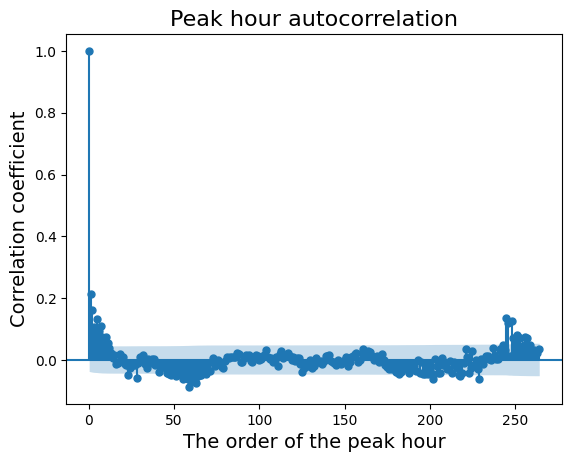

In [137]:
plt.figure(figsize=(20, 4))
autocorr_plot(analyt_df["normalized_peak_hour"], lags=get_average_months_length(analyt_df, 2015, 2023) * 12)
plt.axis("tight")
plt.ylabel("Correlation coefficient", fontsize=14)
plt.xlabel("The order of the peak hour", fontsize=14)
plt.title("Peak hour autocorrelation", fontsize=16)
plt.show();

In [138]:
print("Let's see a separated cases:")

Let's see a separated cases:


In [139]:
# analyt_df["day_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 1)
# analyt_df["week_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 5)
# analyt_df["two_weeks_lag"] = create_lag_feature(analyt_df, "normalized_peak_hour", 10)

In [140]:
# plt.figure(figsize=(20, 4))
# fig, ax = plt.subplots()
# ax = sns.regplot(x="day_lag", y="normalized_peak_hour", data=analyt_df.dropna(), ci=None,
#                  scatter_kws=dict(color="0.25"))
# ax.set_aspect("equal")
# plt.ylabel("Current normalized peak hour", fontsize=14)
# plt.xlabel("Day lag normalized peak hour", fontsize=14)
# ax.set_title("Lag plot of normalized peak hour")

In [141]:
# plt.figure(figsize=(20, 4))
# autocorr_plot(analyt_df["normalized_peak_hour"], lags=get_average_months_length(analyt_df, 2012, 2023) * 30)
# plt.axis("tight")
# plt.ylabel("Correlation coefficient", fontsize=14)
# plt.xlabel("The order of the peak hour", fontsize=14)
# plt.title("Autocorrelation", fontsize=16)
# plt.show();

In [142]:
# print("There is a strong changing correlation.")

In [143]:
featured_df["lag_1"] = create_lag_feature(featured_df, "normalized_peak_hour", 1)
featured_df["lag_2"] = create_lag_feature(featured_df, "normalized_peak_hour", 2)
featured_df["lag_5"] = create_lag_feature(featured_df, "normalized_peak_hour", 5)
featured_df["lag_7"] = create_lag_feature(featured_df, "normalized_peak_hour", 7)
featured_df["lag_10"] = create_lag_feature(featured_df, "normalized_peak_hour", 10)
featured_df["lag_28"] = create_lag_feature(featured_df, "normalized_peak_hour", 28)
featured_df["lag_59"] = create_lag_feature(featured_df, "normalized_peak_hour", 59)
featured_df["lag_245"] = create_lag_feature(featured_df, "normalized_peak_hour", 245)
featured_df["lag_247"] = create_lag_feature(featured_df, "normalized_peak_hour", 247)

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH FEATURES

* TIME DUMMIE FEATURE

In [144]:
# featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [145]:
# featured_df.head(2)

In [146]:
# featured_df.tail(2)

* DATETIME FEATURE

In [147]:
# featured_df = pd.concat([featured_df, create_dayofweek_features(featured_df)[
#     ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday"]]],
#                         axis=1)

In [148]:
# featured_df.head(2)

In [149]:
featured_df["day_of_month"] = featured_df.index.day
featured_df["day_of_year"] = featured_df.index.dayofyear
featured_df["week_of_year"] = featured_df.index.isocalendar().week
featured_df["month"] = featured_df.index.month
featured_df["quarter"] = featured_df.index.quarter
featured_df["year"] = featured_df.index.year

In [150]:
# featured_df.head(2)

* HOLIDAYS FEATURE

In [151]:
# print("Current dataframe has a holidays?", f"Answer: {sum(create_holiday_feature(df)) > 0}.")

* ROLLING MEAN WINDOW FEATURES

In [152]:
# featured_df["rolling_mean_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean", 5).shift(
#     1)

In [153]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.title("Mean week")
# plt.grid(color='r', linestyle='-');

In [154]:
# featured_df["rolling_mean_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "mean",
#                                                                   get_average_months_length(featured_df, 2012,
#                                                                                             2023)).shift(1)

In [155]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_month")
# plt.title("Mean month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [156]:
# featured_df["rolling_mean_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [157]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_quarter")
# plt.title("Mean quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [158]:
# featured_df["rolling_mean_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [159]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_semiannual")
# plt.title("Mean semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [160]:
# featured_df["rolling_mean_annual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 12
# ).shift(1)

In [161]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_annual")
# plt.title("Mean annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [162]:
# featured_df["rolling_mean_quinquennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 60
# ).shift(1)

In [163]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_quinquennial")
# plt.title("Mean quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [164]:
# featured_df["rolling_mean_decennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "mean",
#     get_average_months_length(featured_df, 2012, 2023) * 120
# ).shift(1)

In [165]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_mean_decennial")
# plt.title("Mean decennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MEDIAN WINDOW FEATURES

In [166]:
# featured_df["rolling_median_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "median",
#                                                                    5).shift(1)

In [167]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_week")
# plt.title("Median week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [168]:
# featured_df["rolling_median_month"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023)
# ).shift(1)

In [169]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_month")
# plt.title("Median month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [170]:
# featured_df["rolling_median_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [171]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_quarter")
# plt.title("Median quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [172]:
# featured_df["rolling_median_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "median",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [173]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_median_semiannual")
# plt.title("Median semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MAX WINDOW FEATURES

In [174]:
# featured_df["rolling_max_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "max", 5).shift(1)

In [175]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_week")
# plt.title("Max week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [176]:
# featured_df["rolling_max_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "max",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [177]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_month")
# plt.title("Max month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [178]:
# featured_df["rolling_max_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "max",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [179]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_max_quarter")
# plt.title("Max quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING MIN WINDOW FEATURES

In [180]:
# featured_df["rolling_min_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "min", 5).shift(1)

In [181]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_week")
# plt.title("Min week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [182]:
# featured_df["rolling_min_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "min",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [183]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_month")
# plt.title("Min month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [184]:
# featured_df["rolling_min_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "min",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [185]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_min_quarter")
# plt.title("Min quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

* ROLLING STD WINDOW FEATURES

In [186]:
# featured_df["rolling_std_week"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "std", 5).shift(1)

In [187]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_week")
# plt.title("Std week")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [188]:
# featured_df["rolling_std_month"] = create_rolling_window_feature(featured_df, "normalized_peak_hour", "std",
#                                                                  get_average_months_length(featured_df, 2012,
#                                                                                            2023)).shift(1)

In [189]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_month")
# plt.title("Std month")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [190]:
# featured_df["rolling_std_quarter"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 3
# ).shift(1)

In [191]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_quarter")
# plt.title("Std quarter")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [192]:
# featured_df["rolling_std_semiannual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 6
# ).shift(1)

In [193]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_semiannual")
# plt.title("Std semiannual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [194]:
# featured_df["rolling_std_annual"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 12
# ).shift(1)

In [195]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_annual")
# plt.title("Std annual")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

In [196]:
# featured_df["rolling_std_quinquennial"] = create_rolling_window_feature(
#     featured_df,
#     "normalized_peak_hour",
#     "std",
#     get_average_months_length(featured_df, 2012, 2023) * 60
# ).shift(1)

In [197]:
# plt.figure(figsize=(18, 4))
# sns.lineplot(featured_df, x=featured_df.index, y="rolling_std_quinquennial")
# plt.title("Std quinquennial")
# plt.ylabel("Hour")
# plt.xlabel("Datetime")
# plt.grid(color='r', linestyle='-');

________________________________________________________________________________________________________________________________________________________

#### WORKING WITH LAG FEATURES

In [198]:
# featured_df

In [199]:
# featured_df["day_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 1)
# featured_df["week_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 5)
# featured_df["month_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 25)
# featured_df["quarter_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 75)
# featured_df["half_year_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 120)
# featured_df["year_lag"] = create_lag_feature(featured_df, "normalized_peak_hour", 240)

________________________________________________________________________________________________________________________________________________________

In [200]:
# featured_df

MAKE PREDICTIONS:

In [201]:
# featured_df = featured_df.drop("time_dummie", axis=1)

In [202]:
# featured_df

In [203]:
# std_norm = featured_df["std_norm"]
# mean_norm = featured_df["mean_norm"]

In [204]:
featured_df.columns

Index(['peak_hour', 'std_normalization', 'mean_normalization',
       'normalized_peak_hour', 'time_dummie', 'mean', 'lag_1', 'lag_2',
       'lag_5', 'lag_7', 'lag_10', 'lag_28', 'lag_59', 'lag_245', 'lag_247',
       'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter',
       'year'],
      dtype='object')

In [205]:
featured_df.dropna(inplace=True)

In [206]:
featured_df

,peak_hour,std_normalization,mean_normalization,normalized_peak_hour,time_dummie,mean,lag_1,lag_2,lag_5,lag_7,...,lag_28,lag_59,lag_245,lag_247,day_of_month,day_of_year,week_of_year,month,quarter,year
days,,,,,,,,,,,,,,,,,,,,,
2015-04-03,20,0.776973,19.238095,0.341618,744,1.414838,0.360219,0.383076,0.473065,0.546890,...,0.133741,-0.278317,-2.884385,-3.191436,3,93,14,4,2,2015
2015-04-06,21,0.766356,19.269841,1.632548,745,1.423206,0.341618,0.360219,0.439912,0.508846,...,1.945020,-0.324644,-2.753024,-3.028818,6,96,15,4,2,2015
2015-04-07,21,0.779276,19.317460,1.551871,746,1.431671,1.632548,0.341618,0.409779,0.473065,...,1.755348,-0.377068,-2.630976,-2.884385,7,97,15,4,2,2015
2015-04-08,21,0.789070,19.365079,1.486915,747,1.440284,1.551871,1.632548,0.383076,0.439912,...,1.601691,-0.435406,-2.515401,-2.753024,8,98,15,4,2,2015
2015-04-09,21,0.795855,19.412698,1.436258,748,1.449101,1.486915,1.551871,0.360219,0.409779,...,-0.077256,-0.487451,-2.404113,-2.630976,9,99,15,4,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,16,1.557073,14.650794,-0.618245,3051,-0.090812,-1.222768,-0.517541,-0.299307,-0.773820,...,0.583732,1.071475,1.294456,1.901072,26,239,35,8,3,2024
2024-08-27,16,1.565763,14.666667,-0.664067,3052,-0.057488,-0.618245,-1.222768,0.255569,-0.869776,...,0.949924,1.255573,1.059349,1.583165,27,240,35,8,3,2024
2024-08-28,15,1.574242,14.682540,-1.337643,3053,-0.033376,-0.664067,-0.618245,-1.087169,-0.299307,...,0.601391,0.684835,-1.078517,1.294456,28,241,35,8,3,2024


In [207]:
featured_df.to_parquet("../../model_development/feature_data.gzip")

In [208]:
zxc = featured_df.copy()

In [209]:
y = featured_df["normalized_peak_hour"].copy()

In [210]:
featured_df = featured_df.drop(
    columns=["peak_hour", "std_normalization", "mean_normalization", "time_dummie"], axis=1)

In [211]:
featured_df

,normalized_peak_hour,mean,lag_1,lag_2,lag_5,lag_7,lag_10,lag_28,lag_59,lag_245,lag_247,day_of_month,day_of_year,week_of_year,month,quarter,year
days,,,,,,,,,,,,,,,,,
2015-04-03,0.341618,1.414838,0.360219,0.383076,0.473065,0.546890,0.671635,0.133741,-0.278317,-2.884385,-3.191436,3,93,14,4,2,2015
2015-04-06,1.632548,1.423206,0.341618,0.360219,0.439912,0.508846,0.628523,1.945020,-0.324644,-2.753024,-3.028818,6,96,15,4,2,2015
2015-04-07,1.551871,1.431671,1.632548,0.341618,0.409779,0.473065,0.586873,1.755348,-0.377068,-2.630976,-2.884385,7,97,15,4,2,2015
2015-04-08,1.486915,1.440284,1.551871,1.632548,0.383076,0.439912,0.546890,1.601691,-0.435406,-2.515401,-2.753024,8,98,15,4,2,2015
2015-04-09,1.436258,1.449101,1.486915,1.551871,0.360219,0.409779,0.508846,-0.077256,-0.487451,-2.404113,-2.630976,9,99,15,4,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,-0.618245,-0.090812,-1.222768,-0.517541,-0.299307,-0.773820,-2.894654,0.583732,1.071475,1.294456,1.901072,26,239,35,8,3,2024
2024-08-27,-0.664067,-0.057488,-0.618245,-1.222768,0.255569,-0.869776,-2.969500,0.949924,1.255573,1.059349,1.583165,27,240,35,8,3,2024
2024-08-28,-1.337643,-0.033376,-0.664067,-0.618245,-1.087169,-0.299307,-0.675978,0.601391,0.684835,-1.078517,1.294456,28,241,35,8,3,2024


In [212]:
# true_val = featured_df["peak_hour"]

In [213]:
# featured_df.drop(columns=["peak_hour"], axis=1, inplace=True)

In [214]:
# featured_df

In [215]:
# featured_df["time_dummie"] = create_time_dummie_feature(featured_df)

In [216]:
featured_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2312 entries, 2015-04-03 to 2024-08-30
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   normalized_peak_hour  2312 non-null   float64
 1   mean                  2312 non-null   float64
 2   lag_1                 2312 non-null   float64
 3   lag_2                 2312 non-null   float64
 4   lag_5                 2312 non-null   float64
 5   lag_7                 2312 non-null   float64
 6   lag_10                2312 non-null   float64
 7   lag_28                2312 non-null   float64
 8   lag_59                2312 non-null   float64
 9   lag_245               2312 non-null   float64
 10  lag_247               2312 non-null   float64
 11  day_of_month          2312 non-null   int32  
 12  day_of_year           2312 non-null   int32  
 13  week_of_year          2312 non-null   UInt32 
 14  month                 2312 non-null   int32  
 15  qua

In [217]:
featured_df.drop(columns=["normalized_peak_hour", "mean"], inplace=True)

In [218]:
train_x = featured_df[: 1900]
test_x = featured_df[1900:]

In [219]:
train_y = y[: 1900]
test_y = y[1900:]

In [220]:
from xgboost import XGBRegressor

In [221]:
model = XGBRegressor(n_estimators=100, max_depth=3)

In [222]:
# help(model)

In [223]:
# help(model.fit)

In [224]:
model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], eval_metric="mae", verbose=10,
          early_stopping_rounds=6)

[0]	validation_0-mae:0.70844	validation_1-mae:0.79307
[8]	validation_0-mae:0.56854	validation_1-mae:0.78439


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [225]:
data = pd.concat([train_x, test_x], axis=0)

In [226]:
target = pd.concat([train_y, test_y], axis=0)

In [227]:
# model.fit(data, target)

In [228]:
import pickle

In [229]:
file_name = "xgb_reg.pkl"

pickle.dump(model, open(model_path + file_name, "wb"))

_________________________________________________________________________________________________________________________________________________________

In [230]:
zxc_index = zxc
freq = 245

time = np.arange(len(zxc), dtype=np.float32)
k = 2 * np.pi * (1 / freq) * time
features = {}

for i in [1, 2, 5]:
    features.update({
        f"sin_{freq}_{i}": np.sin(i * k),
        f"cos_{freq}_{i}": np.cos(i * k),
    })

    sincos = pd.DataFrame(features, index=zxc_index)

In [231]:
sincos.index = zxc.index

In [232]:
zxc = pd.concat([zxc, sincos], axis=1)

In [234]:
dp = DeterministicProcess(index=zxc.index, order=1)

In [235]:
zxc["trend"] = dp.in_sample()

In [236]:
zxc["trend"] += 2537 - 2290

In [237]:
pred = model.predict(zxc[model.feature_names_in_])

In [238]:
pred = pred + season_model.predict(zxc[season_model.feature_names_in_])

In [239]:
pred = pred + trend_model.predict(zxc[trend_model.feature_names_in_])

In [240]:
res = pred * zxc["std_normalization"] + zxc["mean_normalization"]

In [241]:
import datetime

In [242]:
model.feature_names_in_

array(['lag_1', 'lag_2', 'lag_5', 'lag_7', 'lag_10', 'lag_28', 'lag_59',
       'lag_245', 'lag_247', 'day_of_month', 'day_of_year',
       'week_of_year', 'month', 'quarter', 'year'], dtype='<U12')

In [244]:
dd = 1
lst = [1, 2, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30]

freq = 245

In [248]:
for _ in range(31):
    new_df = processed_df.copy()

    if (new_df.index[-1] + datetime.timedelta(days=dd)).day not in lst:
        dd += 1
        continue
    else:
        day_node = new_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        new_df = pd.concat([new_df, day_node], axis=0)
        # С НОВЫМ ДНЁМ DF

        new_df["day_of_month"] = new_df.index.day

        new_df = normalization(new_df, "peak_hour")
        # НСРМАЛИЗОВАННЫЙ DF

        new_df = new_df["2014-04":]

        dp = DeterministicProcess(index=new_df.index, order=1)
        x = dp.in_sample()
        new_df["trend"] = x

        y_pred = pd.Series(trend_model.predict(x), index=new_df.index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] - y_pred
        # Detrended

        indx = new_df["normalized_peak_hour"]
        freq = 245

        time = np.arange(len(indx), dtype=np.float32)
        k = 2 * np.pi * (1 / freq) * time
        features = {}

        for i in [1, 2, 5]:
            features.update({
                f"sin_{freq}_{i}": np.sin(i * k),
                f"cos_{freq}_{i}": np.cos(i * k),
            })

        fourier_features = pd.DataFrame(features, index=indx)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_df["normalized_peak_hour"].index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] - y_pred

        new_df["lag_1"] = create_lag_feature(new_df, "normalized_peak_hour", 1)
        new_df["lag_2"] = create_lag_feature(new_df, "normalized_peak_hour", 2)
        new_df["lag_5"] = create_lag_feature(new_df, "normalized_peak_hour", 5)
        new_df["lag_7"] = create_lag_feature(new_df, "normalized_peak_hour", 7)
        new_df["lag_10"] = create_lag_feature(new_df, "normalized_peak_hour", 10)
        new_df["lag_28"] = create_lag_feature(new_df, "normalized_peak_hour", 28)
        new_df["lag_59"] = create_lag_feature(new_df, "normalized_peak_hour", 59)
        new_df["lag_245"] = create_lag_feature(new_df, "normalized_peak_hour", 245)
        new_df["lag_247"] = create_lag_feature(new_df, "normalized_peak_hour", 247)

        new_df["day_of_month"] = new_df.index.day
        new_df["day_of_year"] = new_df.index.dayofyear
        new_df["week_of_year"] = new_df.index.isocalendar().week
        new_df["month"] = new_df.index.month
        new_df["quarter"] = new_df.index.quarter
        new_df["year"] = new_df.index.year

        new_df["normalized_peak_hour"] = pd.Series(model.predict(new_df[model.feature_names_in_]), index=new_df.index)

        y_pred = pd.Series(season_model.predict(fourier_features), index=new_df["normalized_peak_hour"].index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] + y_pred

        y_pred = pd.Series(trend_model.predict(x), index=new_df.index)
        new_df["normalized_peak_hour"] = new_df["normalized_peak_hour"] + y_pred

        new_df["peak_hour"] = new_df["normalized_peak_hour"] * new_df["std_normalization"] + new_df[
            "mean_normalization"]

        day_node = processed_df.iloc[-1]
        day_node.name += datetime.timedelta(days=dd)
        day_node = pd.DataFrame({"peak_hour": np.nan}, index=[day_node.name])
        main_df = pd.concat([processed_df, day_node], axis=0)
        main_df["peak_hour"][-1] = round(new_df["peak_hour"][-1])
        dd = 1

In [252]:
for i in new_df["2024-08":]["peak_hour"]:
    print(int(i))

14
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
